In [1]:
!pip install sagemaker==1.72.0 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import os
import ast
import json
import numpy as np
import pandas as pd
import source
import math

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import Audio
sound_file = './sound/beep.wav'

import warnings
warnings.filterwarnings('ignore')

session = sagemaker.Session()
role = get_execution_role()

<h2> Data Processing </h2>

ROI is calculated using next price because we are trying to predict future ROI using the data from current time period.
Referred to https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb & https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

In [4]:
DATA_DIR = './data'

In [5]:
data = pd.read_csv(os.path.join(DATA_DIR, 'crypto-historical-data.csv'), 
                   parse_dates=['time'], 
                   index_col=0, 
                   keep_default_na=False,
                   header=0,
                   names=['market_cap', 'name', 'price', 'sym', 'time', 'volume'])

data.sort_values(by=['sym', 'time'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [6]:
data['rank'] = data.groupby("time")["market_cap"] \
                    .rank("dense", ascending=False) \
                    .astype(int)

data['market_share'] = data.groupby('time')["market_cap"] \
                    .apply(lambda x: x/float(x.sum()))

data['age'] = data.groupby(['sym'])["time"] \
                    .apply(lambda x: x - min(x)) \
                    .dt.days + 1

previous_price = data.groupby(['sym'])['price'].shift(-1)
data['roi'] = data['price']/previous_price - 1

In [7]:
data[data['sym'] == 'ETH'].head(10)

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
224231,167911000.0,Ethereum,0.753325,ETH,2015-08-08,674188.0,4,0.034732,1,0.073270
224232,42637600.0,Ethereum,0.701897,ETH,2015-08-09,532170.0,4,0.009641,2,-0.009247
224233,43130000.0,Ethereum,0.708448,ETH,2015-08-10,405283.0,4,0.009581,3,-0.337899
224234,42796500.0,Ethereum,1.070000,ETH,2015-08-11,1463100.0,4,0.009541,4,-0.122951
224235,64018400.0,Ethereum,1.220000,ETH,2015-08-12,2150620.0,4,0.013904,5,-0.333333
224236,73935400.0,Ethereum,1.830000,ETH,2015-08-13,4068680.0,4,0.016312,6,0.000000
224237,109594000.0,Ethereum,1.830000,ETH,2015-08-14,4637030.0,4,0.024201,7,0.082840
224238,109160000.0,Ethereum,1.690000,ETH,2015-08-15,2554360.0,4,0.023926,8,0.076433
224239,102028000.0,Ethereum,1.570000,ETH,2015-08-16,3550790.0,4,0.022676,9,0.308333
224240,95819700.0,Ethereum,1.200000,ETH,2015-08-17,1942830.0,4,0.021582,10,0.100917


<h2> Data Selection </h2>

In [8]:
filtered = data.query('volume > 100000 & sym != ""')
filtered = filtered.query('sym == "ETH"')

In [9]:
filtered.sort_values(by=['sym', 'time'], inplace=True)
filtered.reset_index(drop=True, inplace=True)

<h2> Feature Engineering </h2>

In [10]:
feat = filtered.copy()

In [11]:
W = 3
TARGET = 'price'

In [12]:
properties = ['market_cap', 'price', 'volume', 'rank', 'market_share', 'age', 'roi']
feat_columns = []

for p in properties:
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        feat[col_name] = feat.groupby(['sym'])[p].shift(w)
        feat_columns.append(col_name)
    
    feat[p + '_mean'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(w, min_periods=1).mean())
    feat[p + '_std'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(w, min_periods=1).std())

feat.dropna(inplace=True)

In [13]:
feat.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_lag_1,age_lag_2,age_lag_3,age_mean,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_mean,roi_std
3,42796500.0,Ethereum,1.07,ETH,2015-08-11,1463100.0,4,0.009541,4,-0.122951,...,3.0,2.0,1.0,2.0,1.0,-0.337899,-0.009247,0.073270,-0.091292,0.217517
4,64018400.0,Ethereum,1.22,ETH,2015-08-12,2150620.0,4,0.013904,5,-0.333333,...,4.0,3.0,2.0,3.0,1.0,-0.122951,-0.337899,-0.009247,-0.156699,0.166905
5,73935400.0,Ethereum,1.83,ETH,2015-08-13,4068680.0,4,0.016312,6,0.000000,...,5.0,4.0,3.0,4.0,1.0,-0.333333,-0.122951,-0.337899,-0.264728,0.122804
6,109594000.0,Ethereum,1.83,ETH,2015-08-14,4637030.0,4,0.024201,7,0.082840,...,6.0,5.0,4.0,5.0,1.0,0.000000,-0.333333,-0.122951,-0.152095,0.168567
7,109160000.0,Ethereum,1.69,ETH,2015-08-15,2554360.0,4,0.023926,8,0.076433,...,7.0,6.0,5.0,6.0,1.0,0.082840,0.000000,-0.333333,-0.083498,0.220293


<h2> Data Split </h2>

In [14]:
VAL_START = pd.Timestamp('2017-04-25')
TEST_START = pd.Timestamp('2017-10-25')

In [15]:
train = feat.query("time < @VAL_START")
val = feat.query("time >= @VAL_START & time < @TEST_START")
trainval = feat.query("time <= @TEST_START")
test = feat.query("time >= @TEST_START")

In [16]:
cols_to_scale = feat_columns + [TARGET]

In [17]:
scaler_train = StandardScaler()
train_cols_scaled = scaler_train.fit_transform(train[cols_to_scale])
train_scaled = train.copy()
train_scaled[cols_to_scale] = train_cols_scaled

In [18]:
print(cols_to_scale)
print(scaler_train.var_)
print(scaler_train.mean_)

['market_cap_lag_1', 'market_cap_lag_2', 'market_cap_lag_3', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3', 'rank_lag_1', 'rank_lag_2', 'rank_lag_3', 'market_share_lag_1', 'market_share_lag_2', 'market_share_lag_3', 'age_lag_1', 'age_lag_2', 'age_lag_3', 'roi_lag_1', 'roi_lag_2', 'roi_lag_3', 'price']
[9.44029540e+17 9.25097659e+17 9.06196744e+17 1.17463805e+02
 1.15293085e+02 1.13101657e+02 1.90377237e+15 1.90423395e+15
 1.90462687e+15 7.82296608e-01 7.85099799e-01 7.87882379e-01
 1.71415743e-03 1.70741731e-03 1.69725494e-03 3.23440000e+04
 3.23440000e+04 3.23440000e+04 5.28228005e-03 5.28118028e-03
 5.29072712e-03 1.19814276e+02]
[ 8.87641789e+08  8.80615461e+08  8.73852413e+08  1.04847740e+01
  1.04080676e+01  1.03313474e+01  2.24390934e+07  2.23817871e+07
  2.23229053e+07  2.56179775e+00  2.56500803e+00  2.56821830e+00
  6.39788099e-02  6.37561402e-02  6.35737997e-02  3.14000000e+02
  3.13000000e+02  3.12000000e+02 -4.12331908e-03 -4.08

In [19]:
scaler_trainval = StandardScaler()
trainval_cols_scaled = scaler_trainval.fit_transform(trainval[cols_to_scale])
trainval_scaled = trainval.copy()
trainval_scaled[cols_to_scale] = trainval_cols_scaled

In [20]:
def scale_col(df, base, col):
    mean = df[base + '_mean']
    std = df[base + '_std']
    std = np.where(std == 0, 0.001, std)
    return (df[col] - mean)/std

In [21]:
val_scaled = val.copy()
for p in properties:
    val_scaled[p] = scale_col(val_scaled, p, p)
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        val_scaled[col_name] = scale_col(val_scaled, p, col_name)

In [22]:
test_scaled = test.copy()
for p in properties:
    test_scaled[p] = scale_col(test_scaled, p, p)
    
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        test_scaled[col_name] = scale_col(test_scaled, p, col_name)

In [23]:
test_scaled.describe()

,market_cap,price,volume,rank,market_share,age,roi,market_cap_lag_1,market_cap_lag_2,market_cap_lag_3,...,age_lag_1,age_lag_2,age_lag_3,age_mean,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_mean,roi_std
count,169.000000,169.000000,169.000000,1.690000e+02,169.000000,169.0,169.000000,169.000000,169.000000,169.000000,...,169.0,169.0,169.0,169.000000,169.0,169.000000,169.000000,169.000000,169.000000,169.000000
mean,-0.008263,0.138561,1.001767,-2.511383e+05,0.132466,2.0,-0.038068,0.049450,-0.014020,-0.035430,...,1.0,0.0,-1.0,892.000000,1.0,-0.013550,0.003842,0.009708,-0.000023,0.052698
std,4.270688,4.687974,6.175089,3.264875e+06,3.185049,0.0,2.760861,0.850413,0.726003,0.870460,...,0.0,0.0,0.0,48.930222,0.0,0.829504,0.811678,0.815299,0.038751,0.033079
min,-39.450642,-36.711017,-4.481230,-4.244337e+07,-6.144347,2.0,-23.480780,-1.154553,-1.154611,-1.154272,...,1.0,0.0,-1.0,808.000000,1.0,-1.154114,-1.154698,-1.154657,-0.141598,0.003867
25%,-0.972459,-1.025454,-1.167391,0.000000e+00,-1.592107,2.0,-0.896394,-0.904223,-0.652847,-0.931094,...,1.0,0.0,-1.0,850.000000,1.0,-0.807305,-0.819199,-0.735484,-0.022587,0.027951
50%,0.325622,0.220591,-0.301052,0.000000e+00,-0.405553,2.0,0.013335,0.116236,-0.032222,-0.078923,...,1.0,0.0,-1.0,892.000000,1.0,0.052858,-0.019004,-0.018394,-0.001695,0.045372
75%,1.365829,1.372667,1.157391,0.000000e+00,1.305166,2.0,0.882467,0.927361,0.641495,0.884976,...,1.0,0.0,-1.0,934.000000,1.0,0.774539,0.795376,0.791792,0.016428,0.066495
max,10.454987,26.733397,52.275250,1.000000e+03,23.728305,2.0,9.015980,1.154245,1.154700,1.154471,...,1.0,0.0,-1.0,976.000000,1.0,1.154691,1.154700,1.154700,0.107638,0.171788


In [24]:
test_scaled.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_lag_1,age_lag_2,age_lag_3,age_mean,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_mean,roi_std
809,0.644398,Ethereum,0.735762,ETH,2017-10-25,-0.966470,0.0,5.409184,2.0,0.209032,...,1.0,0.0,-1.0,808.0,1.0,0.109770,-1.050356,0.940586,-0.002394,0.034038
810,0.788165,Ethereum,0.329314,ETH,2017-10-26,-1.260235,0.0,0.380912,2.0,0.323134,...,1.0,0.0,-1.0,809.0,1.0,0.646778,0.505018,-1.151796,-0.010694,0.023834
811,0.325622,Ethereum,-0.186917,ETH,2017-10-27,-0.753086,0.0,-0.452637,2.0,0.712785,...,1.0,0.0,-1.0,810.0,1.0,-1.038668,0.956228,0.082441,0.001024,0.003867
812,0.405008,Ethereum,-1.401938,ETH,2017-10-28,-0.548184,0.0,-0.295124,2.0,-7.282861,...,1.0,0.0,-1.0,811.0,1.0,0.461883,-1.147456,0.685573,0.001836,0.004208
813,-1.153368,Ethereum,14.099187,ETH,2017-10-29,43.840972,0.0,0.101809,2.0,0.040576,...,1.0,0.0,-1.0,812.0,1.0,-1.132097,0.762941,0.369157,-0.009341,0.017198


In [25]:
train_X = train_scaled[feat_columns]
train_Y = train_scaled[[TARGET]]

trainval_X = trainval_scaled[feat_columns]
trainval_Y = trainval_scaled[[TARGET]]

val_X = val_scaled[feat_columns]
val_Y = val_scaled[[TARGET]]

test_X = test_scaled[feat_columns]
test_Y = test_scaled[[TARGET]]

<h2> Training </h2>

In [26]:
prefix = 'mlp-new'

pd.concat([train_Y, train_X], axis=1).to_csv(os.path.join(DATA_DIR, 'train.csv'), header=False, index=False)
pd.concat([val_Y, val_X], axis=1).to_csv(os.path.join(DATA_DIR, 'val.csv'), header=False, index=False)
pd.concat([trainval_Y, trainval_X], axis=1).to_csv(os.path.join(DATA_DIR, 'trainval.csv'), header=False, index=False)

train_location = session.upload_data(os.path.join(DATA_DIR, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(DATA_DIR, 'val.csv'), key_prefix=prefix)
trainval_location = session.upload_data(os.path.join(DATA_DIR, 'trainval.csv'), key_prefix=prefix)

train_input = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
val_input = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')
trainval_input = sagemaker.s3_input(s3_data=trainval_location, content_type='text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [27]:
estimator = SKLearn(entry_point='train.py',
                        source_dir='source',
                        role=role,
                        train_instance_count=1, 
                        train_instance_type='ml.c4.xlarge',
                        framework_version='0.23-1',
                        py_version='py3',
                        output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                        sagemaker_session=session,
                        hyperparameters={
                            'hidden_layers': 100,
                            'max_iter': 500
                        })

estimator.fit({'train': train_location, 'validation':val_location})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-02-01 15:07:03 Starting - Starting the training job...
2021-02-01 15:07:06 Starting - Launching requested ML instances......
2021-02-01 15:08:12 Starting - Preparing the instances for training...
2021-02-01 15:09:03 Downloading - Downloading input data......
2021-02-01 15:10:03 Training - Training image download completed. Training in progress.
2021-02-01 15:10:03 Uploading - Uploading generated training model
2021-02-01 15:10:03 Completed - Training job completed
2021-02-01 15:09:51,647 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-02-01 15:09:51,649 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-01 15:09:51,660 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-02-01 15:09:52,020 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-01 15:09:52,032 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus insta

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


------------

<h2> Predicting on Test Set </h2>

In [ ]:
pred_Y = [predictor.predict(batch).decode('utf-8') for batch in np.array_split(test_X.values, 10)]
pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
pred_Y = np.array([val for sublist in pred_Y for val in sublist])

In [ ]:
pred_mean = test_scaled[TARGET+'_mean']
pred_std = test_scaled[TARGET+'_std']
pred = (pred_Y * pred_std) + pred_mean

In [ ]:
test_result = test.copy()
test_result['pred'] = pred
test_result = test_result.set_index('time')

In [ ]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
get_mape(test_result[TARGET], test_result['pred'])

In [ ]:
plt.figure(figsize=(10,5))

test_result[test_result['sym'] == 'ETH']['pred'].plot(label='Prediction', lw=1)
test_result[test_result['sym'] == 'ETH'][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

<h2> Predicting on Train Set </h2>

In [212]:
pred_Y = [predictor.predict(batch).decode('utf-8') for batch in np.array_split(train_X.values, 200)]
pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
pred_Y = np.array([val for sublist in pred_Y for val in sublist])

In [213]:
pred_mean = train[TARGET+'_mean']
pred_std = train[TARGET+'_std']
pred = pred_Y * math.sqrt(scaler_train.var_[-1]) + scaler_train.mean_[-1]
# pred = pred_Y * pred_std + pred_mean

In [214]:
train_result = train.copy()
train_result['pred'] = pred
train_result = train_result.set_index('time')

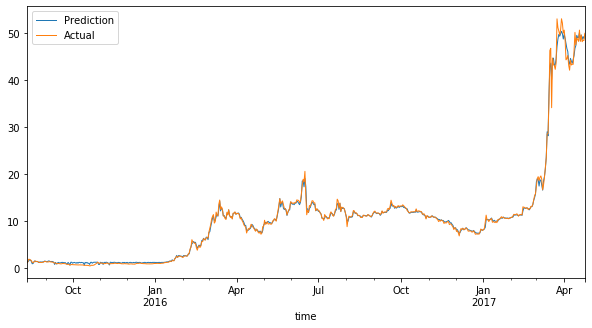

In [215]:
plt.figure(figsize=(10,5))

train_result[train_result['sym'] == 'ETH']['pred'].plot(label='Prediction', lw=1)
train_result[train_result['sym'] == 'ETH']['price'].plot(label='Actual', lw=1)

plt.legend()
plt.show()

In [216]:
predictor.delete_endpoint()

<h2> Trading </h2>

In [ ]:
def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

In [ ]:
# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate_strategy(result, n=10, initial_value=10000):
    total_value = initial_value
    mean_roi = 0
    std_roi = 0
    
    value_history = []
    roi_history = []
    
    t = 1

    dates = list(set(result.index)).sort()

    for date in dates:
        temp_df = result.query('time == @date & pred > 0')
        temp_df['predicted_roi'] = temp_df['pred'] - 
        temp_df.sort_values(by='predicted_roi', ascending=False, inplace=True)

        if not temp_df.empty:
            
            top_n = temp_df.nlargest(n, 'pred')
            day_return = sum(top_n['roi'] * total_value
            sum(coins_stats_df.iloc[:n,:]['actual_roi'] * total_value / n)
            day_roi = day_return/total_value
        else:
            day_return = 0
            day_roi = 0
        
        total_value += day_return
        percent_returns = (total_value/initial_value - 1) * 100

        prev_mean_roi = mean_roi
        mean_roi = update_mean(prev_mean_roi, t, day_roi)
        std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, day_roi)
        sharpe_ratio = mean_roi/std_roi
        
        value_history.append(total_value)
        roi_history.append(day_roi)

        t += 1
        
    print('Cumulative Returns: {:.2e}%, Sharpe Ratio: {:.4f}'.format(percent_returns, sharpe_ratio))
    
    history = pd.concat([pd.DataFrame(dates), pd.DataFrame(value_history), pd.DataFrame(roi_history)], axis=1)
    history.columns = ['time', 'total_value', 'roi']
    history = history.set_index('time')
    return sharpe_ratio, percent_returns, history

In [525]:
cols_to_scale

['market_cap',
 'market_cap_lag_1',
 'market_cap_lag_2',
 'market_cap_lag_3',
 'volume',
 'volume_lag_1',
 'volume_lag_2',
 'volume_lag_3',
 'rank',
 'rank_lag_1',
 'rank_lag_2',
 'rank_lag_3',
 'market_share',
 'market_share_lag_1',
 'market_share_lag_2',
 'market_share_lag_3',
 'age',
 'age_lag_1',
 'age_lag_2',
 'age_lag_3',
 'roi',
 'roi_lag_1',
 'roi_lag_2',
 'roi_lag_3',
 'price']